In [ ]:
%%time

import numpy as np
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
import albumentations as A
import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

images = np.load("/kaggle/input/brain-tumor/brain_tumor_dataset/images.npy", allow_pickle=True)
masks = np.load("/kaggle/input/brain-tumor/brain_tumor_dataset/masks.npy", allow_pickle=True)
labels = np.load("/kaggle/input/brain-tumor/brain_tumor_dataset/labels.npy")
integer_to_class = {1: 'meningioma', 2: 'glioma', 3: 'pituitary tumor'}

print(f"images:{images.shape}")
print(f"masks:{masks.shape}")
print(f"labels:{labels.shape}")

data = np.column_stack((images, masks, labels))
data.shape

from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size=0.08, random_state=42)
train_data, test_data = train_test_split(train_data, test_size=0.12, random_state=42)

print("Train:", train_data.shape,
      "\nVal:", val_data.shape,
      "\nTest:", test_data.shape,)

In [ ]:
  import torch
  import torch.nn as nn
  import torch.nn.functional as F
  from torch.utils.data import Dataset, DataLoader

  import albumentations as A


  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  from matplotlib.colors import Normalize
  class BrainMriDataset(Dataset):
      def __init__(self, data, transforms, n_classes=3):
          self.data = data
          self.transforms = transforms
          self.n_classes = n_classes

      def __len__(self):
          return len(self.data)

      def __getitem__(self, idx):
          image = self.data[idx][0].astype("float32")

          norm = Normalize(vmin= image.min(), vmax = image.max())
          image = norm(image)

          # медианный фильтр
          image = cv2.medianBlur(image, 3)

          # конвертируем в формат РГБ под Resnet50
          image_rgb = np.stack([image]*3).transpose(1,2,0)

          # create target label
          label = self.data[idx][2]

          # augmentations
          augmented = self.transforms(image=image_rgb)
          image = augmented['image']

          return image, label

In [ ]:
# Определяем последовательность операций для аугментации
transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.CoarseDropout(
        max_holes=8,
        max_height=8,
        max_width=8,
        min_holes=2,
        min_height=2,
        min_width=2,
        fill_value=0,
        p=0.5
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.2,
        contrast_limit=0.1,
        p=0.3
    )
])


In [ ]:
import os

# Создаем папки под каждую выборку
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/validation'
test_dir = '/kaggle/working/test'

if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Создадим подкаталоги для каждого класса в каталогах train, validation и test
for i in range(1, 4):
    os.makedirs(os.path.join(train_dir, str(i)))
    os.makedirs(os.path.join(val_dir, str(i)))
    os.makedirs(os.path.join(test_dir, str(i)))


In [ ]:
-==============================================7# train
j  = 1
train_dataset=None
train_dataset = BrainMriDataset(data=train_data, transforms=transforms)

for item in train_dataset:
    img, label = item
    plt.imsave('/kaggle/working/train/{}/{}.jpg'.format(label, j), img)
    j+=1
print('Write Completed')

# validation
j  = 1
val_dataset=None
val_dataset = BrainMriDataset(data=val_data, transforms=transforms)

for item in val_dataset:
    img, label = item
    plt.imsave('/kaggle/working/validation/{}/{}.jpg'.format(label, j), img)
    j+=1
print('Write Completed')

# test
j  = 1
test_dataset=None
test_dataset = BrainMriDataset(data=test_data, transforms=transforms)

for item in test_dataset:
    img, label = item
    plt.imsave('/kaggle/working/test/{}/{}.jpg'.format(label, j), img)
    j+=1
print('Write Completed')

#Пробуем дообучить ранее полученную модель для бинарной классификации

In [ ]:
from tensorflow.keras.models import load_model

model456 = load_model('/kaggle/working/clf_model2.keras')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix

# Указываем пути к выборкам и некоторые гиперпараметры
train_dir = 'train/'
valid_dir = 'validation/'
test_dir = 'test/'
input_shape = (256, 256, 3)
batch_size = 32
num_classes = 3
learning_rate = 0.0001
epochs = 50

# Определяем генераторы данныж
train_datagen = ImageDataGenerator(rescale=1./255,
                                              rotation_range=20,
                                              width_shift_range=0.2,
                                              height_shift_range=0.2,
                                              shear_range=0.2,
                                              zoom_range=0.2,
                                              horizontal_flip=True,
                                              fill_mode='nearest'
                                   )
valid_datagen = ImageDataGenerator(rescale=1./255,
                                   )
test_datagen = ImageDataGenerator(rescale=1./255,
                                  )
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
# Замена выходного слоя на слой для 3 классов
x = model456.layers[-13].output  # Последний слой перед головой
x = AveragePooling2D(pool_size=(3,3))(x)
x = Flatten(name='Flatten')(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)  # Замена на 3 класса

# Создание новой модели с обновленным выходным слоем
model = tf.keras.models.Model(inputs=model456.input, outputs=x)

# Замораживание всех слоев кроме еще 3 последних
for layer in model456.layers[:-16]:
    layer.trainable = False


# Компилируем модль с оптимизатором Адам и функцией потерь категориальная кроссэнтропия
model.compile(
    optimizer=Adam(learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Зададим колбэки
es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=30
)

mc = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

rlr = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=3,
    verbose=1
)

# Обучаем
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[es, mc],
    workers=4,
    use_multiprocessing=True,
)

In [ ]:
model.save('/kaggle/working/model3classes.keras')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix

# Указываем пути к выборкам и некоторые гиперпараметры
train_dir = 'train/'
valid_dir = 'validation/'
test_dir = 'test/'
input_shape = (224, 224, 3)
batch_size = 32
num_classes = 3
learning_rate = 0.0001
epochs = 50

# Определяем генераторы данныж
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
                                              width_shift_range=0.1,
                                              height_shift_range=0.1,
                                              shear_range=0.1,
                                              horizontal_flip=True,
                                              fill_mode='nearest')
valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Определим модель
# Замена выходного слоя на слой для 3 классов
base_model = tf.keras.applications.ResNet50(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

x = base_model.output

x = AveragePooling2D(pool_size=(3,3))(x)
x = Flatten(name='Flatten')(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)


predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)  # Замена числа классов на 3

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[:-38]:
    layer.trainable = False


# Компилируем модль с оптимизатором Адам и функцией потерь категориальная кроссэнтропия
model.compile(
    optimizer=Adam(learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Зададим колбэки
es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10
)

mc = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

rlr = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=3,
    verbose=1
)

# Обучаем модель
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[es, mc],
    workers=4,
    use_multiprocessing=True,
)

Found 2479 images belonging to 3 classes.
Found 246 images belonging to 3 classes.
Found 339 images belonging to 3 classes.
Epoch 1/50
77/77 [==============================] - ETA: 0s - loss: 0.5089 - accuracy: 0.7818
Epoch 1: val_accuracy improved from -inf to 0.66964, saving model to best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 39s 300ms/step - loss: 0.5089 - accuracy: 0.7818 - val_loss: 1.2191 - val_accuracy: 0.6696
Epoch 2/50
77/77 [==============================] - ETA: 0s - loss: 0.2536 - accuracy: 0.9064
Epoch 2: val_accuracy improved from 0.66964 to 0.78571, saving model to best_model.h5
77/77 [==============================] - 26s 326ms/step - loss: 0.2536 - accuracy: 0.9064 - val_loss: 0.9752 - val_accuracy: 0.7857
Epoch 3/50
77/77 [==============================] - ETA: 0s - loss: 0.1878 - accuracy: 0.9248
Epoch 3: val_accuracy improved from 0.78571 to 0.87500, saving model to best_model.h5
77/77 [==============================] - 25s 318ms/step - loss: 0.1878 - accuracy: 0.9248 - val_loss: 0.4458 - val_accuracy: 0.8750
Epoch 4/50
77/77 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9452
Epoch 4: val_accuracy improved from 0.87500 to 0.93304, saving model to best_model.h5
77/77 [==============================] - 23s 283ms/step - loss: 

In [ ]:
model.save('/kaggle/working/model3classes.keras')

11/11 [==============================] - 1s 120ms/step - loss: 0.1334 - accuracy: 0.9676
Test loss: 0.1334
Test accuracy: 0.9676
11/11 [==============================] - 2s 68ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.90      0.94        84
           1       0.97      0.98      0.98       162
           2       0.95      1.00      0.97        93

    accuracy                           0.97       339
   macro avg       0.97      0.96      0.96       339
weighted avg       0.97      0.97      0.97       339



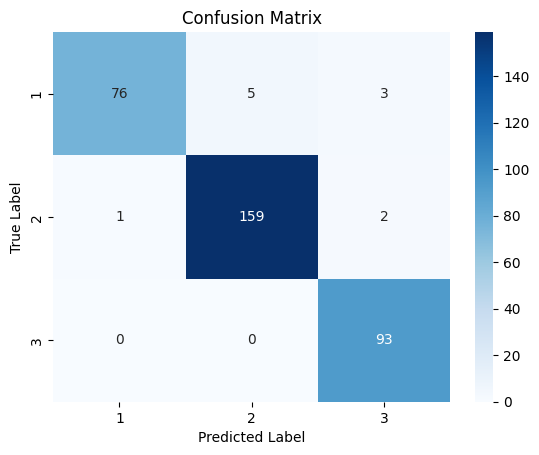

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

# Получаем предсказанные классы и истинные классы для тестовых данных
test_pred = model.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true_classes = test_generator.classes

# Генерируем отчет о классификации
print('Classification Report')
print(classification_report(test_true_classes, test_pred_classes))

# Генерируем confusion matrix
cm = confusion_matrix(test_true_classes, test_pred_classes)

# Определяем метки классов
class_labels = test_generator.class_indices.keys()

# Создаем тепловую карту
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Добавляем метки и заголовок
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()